In [6]:
from packages import *

In [7]:
data_path = "../DATA/A-1/"
output_path = "outputs/A-1/"
filename = lambda gain: f"{data_path}A-1_gain{gain}_100mV.csv"
getrawdata = lambda gain: pd.read_csv(filename(gain))
COLUMN_NAMES = ['frequency [Hz]', 'output p-p [V]', 'input p-p [V]', 'Gain (o/i)']
MILIVOLT_NAMES = ['output p-p [mV]', 'input p-p [mV]']

def get_data(gain):
  # freq, output, input, gain = getrawdata(gain)
  data = getrawdata(gain)
  data.drop(columns=["Gain (o/i)"], inplace=True)

  freq = data['frequency [Hz]']

  if MILIVOLT_NAMES[0] in data.columns:
    output = data[MILIVOLT_NAMES[0]] / 1000
    input = data[MILIVOLT_NAMES[1]] / 1000
  
  else:
    output = data[COLUMN_NAMES[1]]
    input = data[COLUMN_NAMES[2]]

  return freq, output, input

In [28]:
def plot_A_1(gain_true=10, freq_threshold= 6e5 ,xrange=(0.6e3, 4e6), yrange=(-10, 40), save=False):

  xmin, xmax = xrange
  ymin, ymax = yrange
  freq, output, input = get_data(gain_true)
  gain_true = np.log10(gain_true) * 20
  output = np.array(output); input = np.array(input)
  gain = np.array(output / input)
  gain = np.log10(gain) * 20


  x = np.array(freq.unique())
  y = np.zeros((len(x), 2))
  for idx, f in enumerate(x):
    mask = freq == f
    y[idx, 0] = gain[mask].mean()
    y[idx, 1] = gain[mask].std()

  mask = x > freq_threshold
  # linear fit
  x_fit = np.log10(x[mask])
  y_fit = y[mask]
  linear = lambda x, m, c: m * x + c

  popt, pcov = scipy.optimize.curve_fit(linear, x_fit, y_fit[:, 0])
  slope, intercept = popt
  slope_err, intercept_err = np.sqrt(np.diag(pcov))
  
  # x_intersection = 10 ** ((gain_true - intercept) / slope)
  # y_intersection = gain_true
  x_intersection = freq_threshold
  y_intersection = slope * np.log10(freq_threshold) + intercept

  x_intercept = 10 ** ((ymin - intercept) / slope)
  y_intercept = ymin
  y_goal = gain_true - 3
  x_goal = 10 ** ((y_goal - intercept) / slope)
  x_goal_err = x_goal * ((slope_err / slope) ** 2 + (intercept_err / intercept) ** 2)

  R2 = 1 - np.sum((y_fit[:,0] - linear(x_fit, *popt)) ** 2) / np.sum((y_fit[:,0] - y_fit[:,0].mean()) ** 2)

  plt.errorbar(x, y[:, 0], yerr=y[:, 1], fmt='o', ms=5, 
              color='black', label=f'gain: {np.power(10, gain_true/10/2):.1f}',
              capsize=5, capthick=1)

  plt.plot([xmin, xmax], [gain_true, gain_true], '--', label='True gain', color='black')
  plt.plot([x_intercept, x_intersection], [y_intercept, y_intersection], 
          'r--', label='Linear fit')
  plt.plot([x_goal, x_goal], [y_intercept, y_goal], 'g--', label='3 dB frequency')
  xpoint = lambda ratio: 10 ** (np.log10(xmin) * (1 - ratio) + np.log10(xmax) * ratio)
  ypoint = lambda ratio: ymin * (1 - ratio) + ymax * ratio
  plt.text(xpoint(0.05), ypoint(0.9), r'$f_{3dB}' +f'= {x_goal/1000:.1f}\pm{x_goal_err/1000:.1f}$ kHz')
  plt.text(xpoint(0.05), ypoint(0.85), f'$R^2 = {R2:.4f}$')
  plt.text(xpoint(0.05), ypoint(0.8), f'slope $= {slope:.2f}\pm{slope_err:.2f}$')

  plt.legend(loc='lower left')
  plt.xscale("log")
  plt.xlim(xmin, xmax)
  plt.ylim(ymin, ymax)
  plt.xlabel("Frequency [Hz]")
  plt.ylabel("Gain [dB]")
  plt.title(f"Gain vs Frequency for Gain {np.power(10, gain_true/10/2):.0f}")
  if save: plt.savefig(f"{output_path}gain{np.power(10, gain_true/10/2):.0f}.png")
  plt.show()

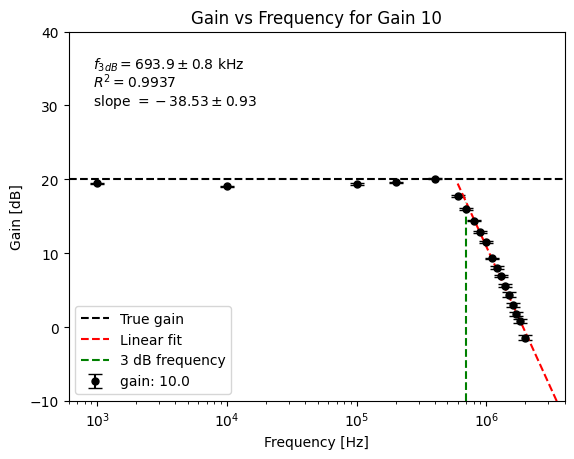

In [29]:
plot_A_1(10, save=True)

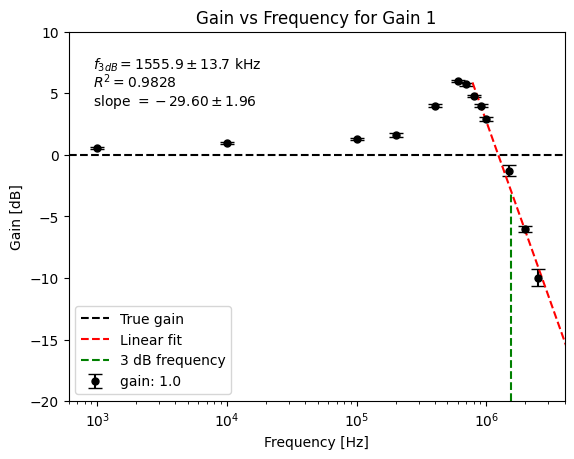

In [30]:
plot_A_1(1,
    freq_threshold= 7.7e5,
    yrange=(-20, 10),
    save=True)                

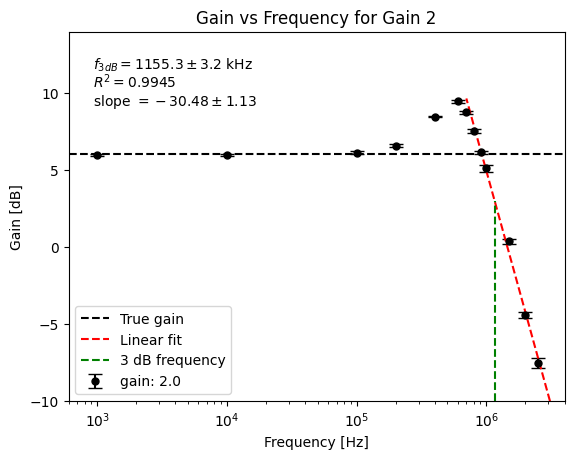

In [31]:
plot_A_1(2,
    freq_threshold= 7e5,
    yrange=(-10, 14),
    save=True)                

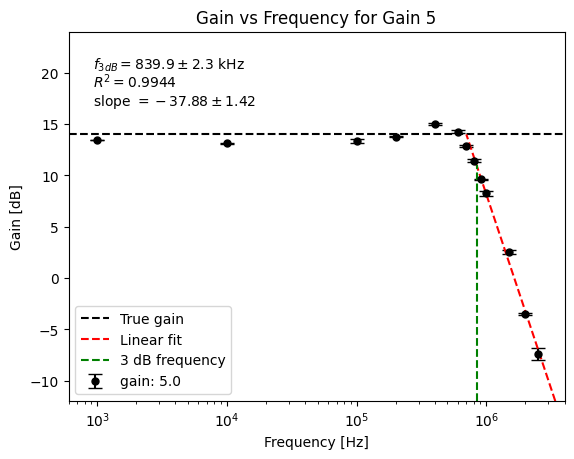

In [32]:
plot_A_1(5,
    freq_threshold= 7e5,
    yrange=(-12, 24),
    save=True)                

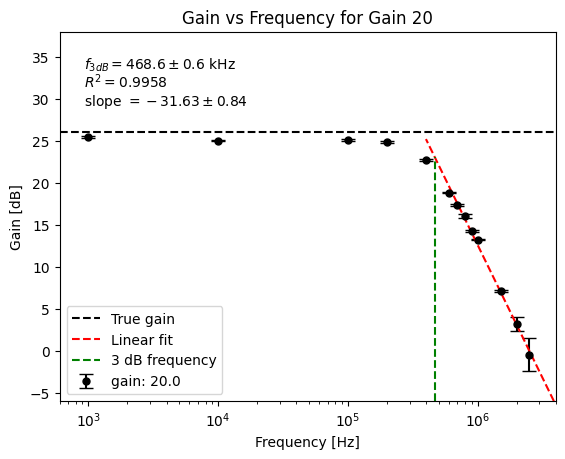

In [33]:
plot_A_1(20,
    freq_threshold= 4e5,
    yrange=(-6, 38),
    save=True)                